In [1]:
import pandas as pd
import numpy as np
import os
import json

In [2]:
# Define the main directory where your data is located
main_directory = r'D:\DevGPT'

# Create an empty DataFrame to store consolidated data
consolidated_data = pd.DataFrame()

# Iterate through each snapshot directory
for snapshot_directory in os.listdir(main_directory):
    snapshot_path = os.path.join(main_directory, snapshot_directory)

    # Check if the path is a directory
    if os.path.isdir(snapshot_path):
        # List the JSON files in the snapshot directory
        json_files = [f for f in os.listdir(snapshot_path) if f.endswith('.json')]

        # Iterate through JSON files in the snapshot
        for json_file in json_files:
            json_file_path = os.path.join(snapshot_path, json_file)
            
            # Read and process the JSON data
            with open(json_file_path, 'r') as file:
                json_data = json.load(file)
            
            # Create a DataFrame from the JSON data
            json_df = pd.DataFrame(json_data)
            
            # Concatenate the JSON DataFrame to the consolidated data
            consolidated_data = pd.concat([consolidated_data, json_df])



In [3]:
prompts = []
answers = []
prompt_answer_pairs = {}

# Iterate through rows in the consolidated_data DataFrame
for index, row in consolidated_data.iterrows():
    # Extract the 'Sources' dictionary from the row
    sources_dict = row['Sources']
    
    # Access the 'ChatgptSharing' key inside the 'Sources' dictionary
    chatgpt_sharing_list = sources_dict.get('ChatgptSharing', [])
    
    # Iterate through the 'Conversations' inside 'ChatgptSharing'
    for chatgpt_sharing in chatgpt_sharing_list:
        for conversation in chatgpt_sharing.get('Conversations', []):
            # Extract prompts and answers from the 'Conversations' dictionary
            prompt = conversation.get('Prompt', '')
            answer = conversation.get('Answer', '')
            
            # Check if both prompt and answer are non-empty
            if prompt and answer:
                prompts.append(prompt)
                answers.append(answer)
                prompt_answer_pairs[prompt] = answer

len(prompts), prompts[:5]  # Show the number of prompts and the first 5 prompts for a preview


(85496,
 ['Write a training plan for a series of lessons to teach someone modern deep learning. The training plan should last for approximately 3 months of lessons.\n\nThe lesson plan is for a single student with a strong background in programming (systems programming, algorithms and web). But the student has little knowledge of python. And university level mathematics knowledge but relatively weak skills in linear algebra and probability and statistics.\n\nBy the end of the training process, the student should know modern deep learning methods and techniques and be able to modify, implement and deploy AI based systems.\n\nThink through your answer. Start by listing out learning objectives, then write a teaching plan to meet those learning objectives.',
  "nine hundred alda in meters.    If you don't have any reference, try the following definition  and use fermi estimation to get in the ballpark :\n\nJochi Khasar, the Khan’s brother, was known far and wide for his ability to hit his t

In [4]:
#Language Complexity Analysis:

In [5]:
import textstat

# Analyze language complexity using Flesch-Kincaid
language_complexity_scores = [textstat.flesch_kincaid_grade(prompt) for prompt in prompts]

# Print average language complexity score
average_language_complexity = sum(language_complexity_scores) / len(language_complexity_scores)
print("Average Language Complexity:", average_language_complexity)


Average Language Complexity: 7.242318938897568


In [6]:
def extract_transformer_features(text, max_length=1024):
    # Tokenize the text
    tokens = tokenizer(text, return_tensors='pt', truncation=True, max_length=max_length)
    
    # Ensure the tokenized input is not empty
    if 'input_ids' in tokens and len(tokens['input_ids'][0]) > 0:
        # Forward pass through the model
        outputs = model(**tokens)
        
        # Extract the last hidden states and calculate the mean
        last_hidden_states = outputs.last_hidden_state
        avg_last_hidden_states = last_hidden_states.mean(dim=1).squeeze().detach().numpy()
        return avg_last_hidden_states
    else:
        # Handle empty tokenized input
        return np.zeros(model.config.hidden_size)


In [7]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import numpy as np

# Example using GPT-2 tokenizer and model (replace with your preferred transformer model)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

In [8]:
# Example: Extract features for each prompt
transformer_features = [extract_transformer_features(prompt) for prompt in prompts]
transformer_features = np.array(transformer_features)


In [9]:
transformer_features

array([[-1.2587640e-01,  7.1513459e-02, -1.1070192e+00, ...,
         1.7822880e-01,  1.2592289e-01, -7.6670051e-02],
       [-1.6064794e-01,  5.2665278e-02, -8.5838538e-01, ...,
         2.2049937e-01, -2.4458979e-01, -3.5561580e-02],
       [-1.4249656e-01, -2.3641640e-01, -2.9893440e-01, ...,
        -2.6515029e-02, -2.5519263e-04,  8.7414905e-02],
       ...,
       [ 4.2092096e-02, -2.3145759e-01, -4.8710462e-01, ...,
        -1.4670871e-01,  8.6598754e-02,  5.2430291e-02],
       [-2.1928298e-01,  8.5009716e-02, -3.0175149e-01, ...,
        -2.8210706e-01,  3.7364181e-02, -3.2246947e-02],
       [ 1.7486441e-01,  4.2586278e-02, -1.3480718e-01, ...,
        -1.4758535e-01,  8.4312804e-02,  3.3670199e-01]], dtype=float32)

In [10]:
# Calculate the length of each conversation (e.g., based on the number of tokens in prompts)
actual_lengths = [len(tokenizer(prompt)['input_ids']) for prompt in prompts]

# Print the first 5 lengths for a preview
print("Actual Lengths:", actual_lengths[:5])

Token indices sequence length is longer than the specified maximum sequence length for this model (1198 > 1024). Running this sequence through the model will result in indexing errors


Actual Lengths: [137, 94, 32, 10, 36]


Mean Squared Error: 6255.77172229077
Mean Absolute Error: 8.387659187717423
R-squared: 0.9840843193855419


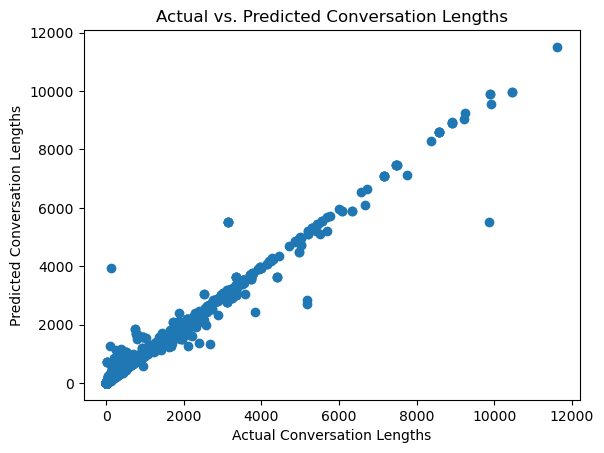

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformer_features, actual_lengths, test_size=0.2, random_state=42)

# Step 2: Train a linear regression model
rf_model = RandomForestRegressor(n_estimators=113, max_depth=15, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: Predict conversation lengths on the testing set
predictions = rf_model.predict(X_test)

# Step 4: Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)



# Step 5: Visualize predicted vs. actual lengths
plt.scatter(y_test, predictions)
plt.xlabel("Actual Conversation Lengths")
plt.ylabel("Predicted Conversation Lengths")
plt.title("Actual vs. Predicted Conversation Lengths")
plt.show()


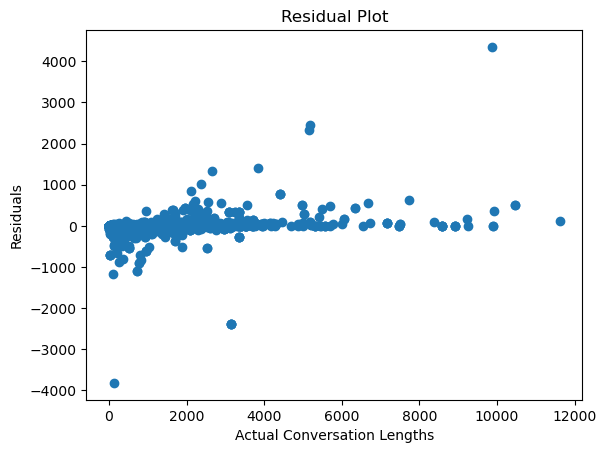

In [13]:
# Create residual plot
residuals = y_test - predictions
plt.scatter(y_test, residuals)
plt.xlabel("Actual Conversation Lengths")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()
